In [1]:
import scanpy as sc

In [2]:
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Arial"
plt.rcParams['pdf.fonttype'] = 42
import seaborn as sns

In [3]:
#read_adata_and_select_tumor_cells
adata = sc.read_h5ad('/data/scPAFA_paper/CRC_file/20231107_cRc_geneover30cells_withobs.h5ad')
adata = adata[adata.obs['MMRStatusTumor'].isin(['MMRp','MMRd'])]
adata = adata[adata.obs[ 'ClusterMidway'].isin(['EpiT'])]
adata.obs['ClusterFull'] = adata.obs['ClusterFull'].str.replace('/','')
adata.obs['ClusterFull'] =adata.obs['ClusterFull'].astype('category')
#batch_information is infered from table S1 of the Cell article,is 10X channel
adata.obs['batch'] = adata.obs['biosample_id'].str[-2:]
adata.obs['batch'] = adata.obs['batch'].astype('category')
adata.obs['batch'].value_counts()

/tmp/ipykernel_1012188/451351291.py:5: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['ClusterFull'] = adata.obs['ClusterFull'].str.replace('/','')


batch
v2    71746
v3    36751
Name: count, dtype: int64

In [4]:
#to avoid overlap sample in differernt group
adata.obs['pseudobulk_sample'] = adata.obs['PatientTypeID'].astype(str)+'_'+adata.obs['batch'].astype(str)
adata.obs['pseudobulk_sample'] = adata.obs['pseudobulk_sample'].astype('category')

In [5]:
#create_sample_meta
sample_meta = adata.obs[['pseudobulk_sample','PatientTypeID','batch','MMRStatusTumor','TumorStage','TissueSource', 'ProcessingMethod','Site', 'Grade']]
sample_meta = sample_meta.drop_duplicates(subset='pseudobulk_sample')
sample_meta.index = sample_meta['pseudobulk_sample']

In [6]:
adata

AnnData object with n_obs × n_vars = 108497 × 26320
    obs: 'ClusterFull', 'ClusterMidway', 'ClusterTop', 'biosample_id', 'donor_id', 'SpecimenType', 'TissueSource', 'ProcessingMethod', 'PatientTypeID', 'sex', 'Site', 'Grade', 'TumorStage', 'LymphNodeStatus', 'MMRStatusTumor', 'MMRMLH1Tumor', 'qc_geneCount', 'qc_logMappedReads', 'qc_meanReadsPerUmi', 'qc_totalReads', 'qc_logUmiCount', 'qc_bcSwapFraction', 'qc_geneSatFraction', 'qc_seqDupEst', 'qc_umiSatFraction', 'qc_emptyDropPval', 'qc_mitoFraction', 'species', 'species__ontology_label', 'disease', 'disease__ontology_label', 'organ', 'organ__ontology_label', 'library_preparation_protocol', 'library_preparation_protocol__ontology_label', 'batch', 'pseudobulk_sample'
    var: 'gene_name', 'gene_id', 'true_gene', 'n_cells'

In [7]:
sample_meta['MMRStatusTumor'].value_counts()

MMRStatusTumor
MMRd    35
MMRp    30
Name: count, dtype: int64

In [8]:
import pandas as pd
Ucell_result = pd.read_parquet('/data/scPAFA_paper/CRC_file/20231109_crc_2k.parquet')
Ucell_result = Ucell_result.loc[adata.obs.index]

In [9]:
import scPAFA

In [10]:
adata.obs['ClusterFull'].value_counts()

ClusterFull
Tumor cE01 (StemTA-like)                   49330
Tumor cE03 (StemTA-like prolif)            38012
Tumor cE02 (StemTA-likeImmature Goblet)     9186
Tumor cE06 (Immature Goblet)                4218
Tumor cE05 (Enterocyte 2)                   3043
Tumor cE04 (Enterocyte 1)                   1903
Tumor cE10 (Tuft)                           1374
Tumor cE08 (Goblet)                          745
Tumor cE11 (Enteroendocrine)                 399
Tumor cE09 (Best4)                           251
Tumor cE07 (GobletEnterocyte)                 36
Name: count, dtype: int64

In [11]:
pseudobulk_table = scPAFA.pb.generate_scpafa_input_multigroup(metadata=adata.obs,
                                                    PAS_dataframe=Ucell_result,
                                                    min_cell_number_per_sample=10,
                                                    min_percentage_sample_per_view=0.75,
                                                    min_sample_per_view=15,
                                                    sample_column='pseudobulk_sample',
                                                    view_column='ClusterFull',
                                                    group_column='batch',
                                                    top_percentage=0.25)

2 groups indentified
processing group v2
Select the top 408 pathways with the maximum variance
Done_Qc
Done_matrix
Done_longtable
processing group v3
Select the top 408 pathways with the maximum variance
Done_Qc
Done_matrix
Done_longtable


In [12]:
pseudobulk_table['view'].value_counts().index

Index(['Tumor cE01 (StemTA-like)', 'Tumor cE03 (StemTA-like prolif)',
       'Tumor cE02 (StemTA-likeImmature Goblet)', 'Tumor cE05 (Enterocyte 2)',
       'Tumor cE06 (Immature Goblet)'],
      dtype='object', name='view')

In [13]:
from scipy.stats import mannwhitneyu
def pairwise_mannwhitneyu(data, category_col, group_col, value_col):
    categories = data[category_col].unique()  # 获取唯一的类别值
    results = {}  # 用于存储结果的字典

    for cat in categories:
        cat_data = data[data[category_col] == cat]  # 根据类别筛选数据
        groups = cat_data[group_col].unique()  # 获取唯一的组别值

        group1 = cat_data[cat_data[group_col] == groups[0]][value_col]
        group2 = cat_data[cat_data[group_col] == groups[1]][value_col]

        # 执行 Mann-Whitney U 检验
        statistic, p_value = mannwhitneyu(group1, group2)

        results[cat] = p_value

    # 创建包含 p 值的数据框
    results_df = pd.DataFrame.from_dict(results, orient='index', columns=['p_value'])
    return results_df

In [14]:
use_obs = adata.obs[adata.obs['ClusterFull'].isin(pseudobulk_table['view'].value_counts().index)]
use_obs["ClusterFull"] = use_obs["ClusterFull"].astype(str).astype('category')

In [15]:
use_obs = use_obs[["ClusterFull","MMRStatusTumor"]]

In [16]:
use_obs.loc[:,'GAVISH_3CA_MALIGNANT_METAPROGRAM_17_INTERFERON_MHC_II_1'] = Ucell_result.loc[use_obs.index,'GAVISH_3CA_MALIGNANT_METAPROGRAM_17_INTERFERON_MHC_II_1']
use_obs.loc[:,'bioplanet_564_PD-1 signaling'] = Ucell_result.loc[use_obs.index,'bioplanet_564_PD-1 signaling']
use_obs.loc[:,'bioplanet_1605_Nef-mediated downregulation of MHC class I complex cell surface expression'] = Ucell_result.loc[use_obs.index,'bioplanet_1605_Nef-mediated downregulation of MHC class I complex cell surface expression']
use_obs.loc[:,'bioplanet_955_Glycolysis'] = Ucell_result.loc[use_obs.index,'bioplanet_955_Glycolysis']
use_obs.loc[:,'GAVISH_3CA_MALIGNANT_METAPROGRAM_METAPROGRAM_6_HYPOXIA'] = Ucell_result.loc[use_obs.index,'GAVISH_3CA_MALIGNANT_METAPROGRAM_METAPROGRAM_6_HYPOXIA']

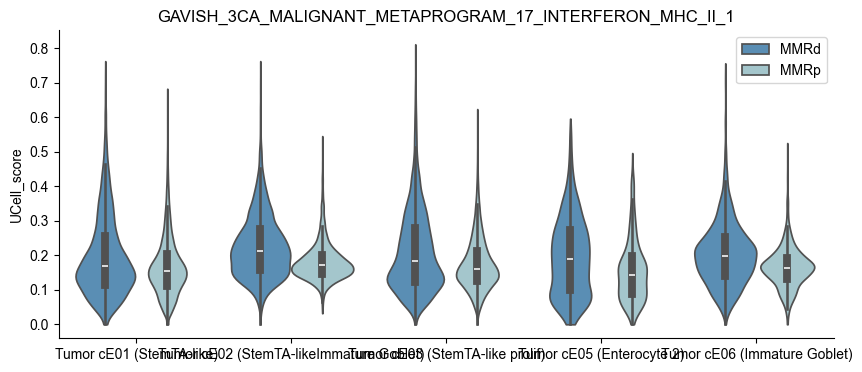

In [28]:
plt.figure(figsize=(10, 4))
sns.violinplot(data=use_obs, x="ClusterFull", y="GAVISH_3CA_MALIGNANT_METAPROGRAM_17_INTERFERON_MHC_II_1", hue="MMRStatusTumor",cut=0,palette=["#4b91c3","#9ecad2"])
plt.legend(loc='best') 
sns.despine()
plt.title('GAVISH_3CA_MALIGNANT_METAPROGRAM_17_INTERFERON_MHC_II_1')
plt.xticks(rotation=0)
plt.xlabel('')
plt.ylabel('UCell_score')
plt.savefig('../CRC/figure_CRC/20240110_CRC_GAVISH_3CA_MALIGNANT_METAPROGRAM_17_INTERFERON_MHC_II_1.pdf',bbox_inches = "tight", transparent=True)
plt.show()

In [18]:
pairwise_mannwhitneyu(use_obs,category_col="ClusterFull",group_col="MMRStatusTumor",value_col='GAVISH_3CA_MALIGNANT_METAPROGRAM_17_INTERFERON_MHC_II_1')

,p_value
Tumor cE01 (StemTA-like),1.116965e-101
Tumor cE03 (StemTA-like prolif),2.975387e-120
Tumor cE05 (Enterocyte 2),5.240070e-23
Tumor cE02 (StemTA-likeImmature Goblet),2.790387e-137
Tumor cE06 (Immature Goblet),2.232789e-50


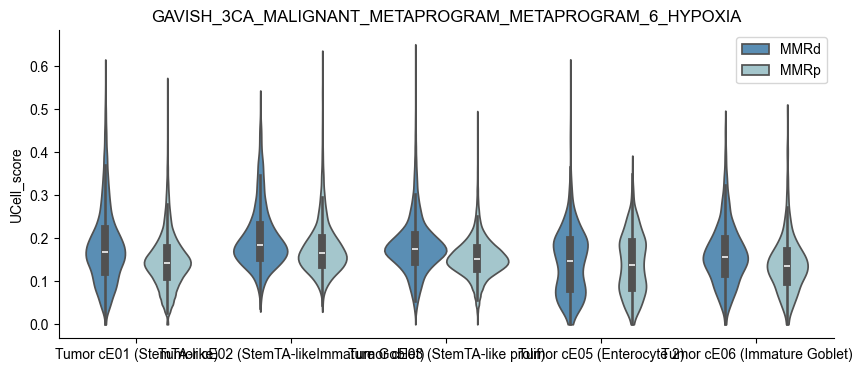

In [19]:
plt.figure(figsize=(10, 4))
sns.violinplot(data=use_obs, x="ClusterFull", y='GAVISH_3CA_MALIGNANT_METAPROGRAM_METAPROGRAM_6_HYPOXIA', hue="MMRStatusTumor",cut=0,palette=["#4b91c3","#9ecad2"])
plt.legend(loc='best') 
sns.despine()
plt.title('GAVISH_3CA_MALIGNANT_METAPROGRAM_METAPROGRAM_6_HYPOXIA')
plt.xticks(rotation=0)
plt.xlabel('')
plt.ylabel('UCell_score')
plt.savefig('../CRC/figure_CRC/20240110_CRC_GAVISH_3CA_MALIGNANT_METAPROGRAM_METAPROGRAM_6_HYPOXIA.pdf',bbox_inches = "tight", transparent=True)
plt.show()

In [20]:
pairwise_mannwhitneyu(use_obs,category_col="ClusterFull",group_col="MMRStatusTumor",value_col='GAVISH_3CA_MALIGNANT_METAPROGRAM_METAPROGRAM_6_HYPOXIA')

,p_value
Tumor cE01 (StemTA-like),0.000000e+00
Tumor cE03 (StemTA-like prolif),0.000000e+00
Tumor cE05 (Enterocyte 2),3.250511e-01
Tumor cE02 (StemTA-likeImmature Goblet),1.568383e-67
Tumor cE06 (Immature Goblet),1.241087e-28


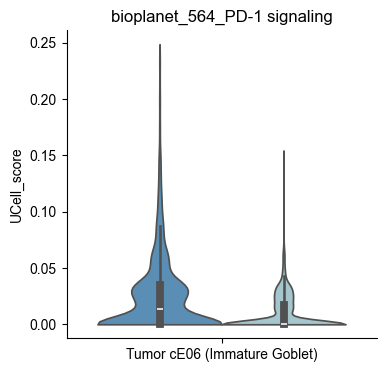

In [21]:
pathway2 = use_obs[use_obs["ClusterFull"] == 'Tumor cE06 (Immature Goblet)'].copy()
pathway2 ["ClusterFull"] = pathway2 ["ClusterFull"].astype(str).astype('category')
plt.figure(figsize=(4, 4))
sns.violinplot(data=pathway2, x="ClusterFull", y="bioplanet_564_PD-1 signaling",cut=0, hue="MMRStatusTumor",palette=["#4b91c3","#9ecad2"])
plt.legend().remove() 
sns.despine()
plt.title('bioplanet_564_PD-1 signaling')
plt.xticks(rotation=0)
plt.xlabel('')
plt.ylabel('UCell_score')
plt.savefig('../CRC/figure_CRC/20240110_CRC_violin_bioplanet_564_PD-1 signaling_View_Tumor cE06.pdf',bbox_inches = "tight", transparent=True)
plt.show()

In [22]:
pairwise_mannwhitneyu(pathway2,category_col="ClusterFull",group_col="MMRStatusTumor",value_col='bioplanet_564_PD-1 signaling')

,p_value
Tumor cE06 (Immature Goblet),3.384116e-55


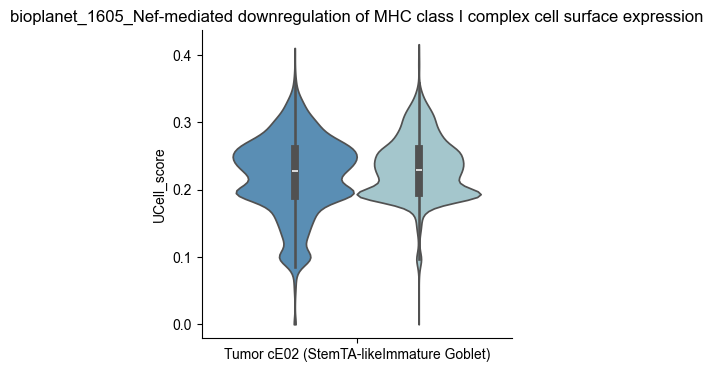

In [23]:
pathway3 = use_obs[use_obs["ClusterFull"] == 'Tumor cE02 (StemTA-likeImmature Goblet)'].copy()
pathway3 ["ClusterFull"] = pathway3 ["ClusterFull"].astype(str).astype('category')
plt.figure(figsize=(4, 4))
sns.violinplot(data=pathway3, x="ClusterFull", y="bioplanet_1605_Nef-mediated downregulation of MHC class I complex cell surface expression",cut=0, hue="MMRStatusTumor",palette=["#4b91c3","#9ecad2"])
plt.legend().remove() 
sns.despine()
plt.title('bioplanet_1605_Nef-mediated downregulation of MHC class I complex cell surface expression')
plt.xticks(rotation=0)
plt.xlabel('')
plt.ylabel('UCell_score')
plt.savefig('../CRC/figure_CRC/20240110_CRC_violin_bioplanet_1605.pdf',bbox_inches = "tight", transparent=True)
plt.show()

In [24]:
pairwise_mannwhitneyu(pathway3,category_col="ClusterFull",group_col="MMRStatusTumor",value_col="bioplanet_1605_Nef-mediated downregulation of MHC class I complex cell surface expression")

,p_value
Tumor cE02 (StemTA-likeImmature Goblet),2.056684e-11


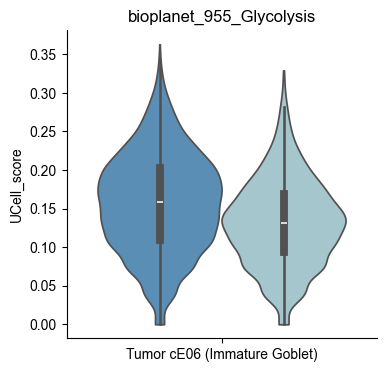

In [25]:
pathway4 = use_obs[use_obs["ClusterFull"] == 'Tumor cE06 (Immature Goblet)'].copy()
pathway4 ["ClusterFull"] = pathway4 ["ClusterFull"].astype(str).astype('category')
plt.figure(figsize=(4, 4))
sns.violinplot(data=pathway4, x="ClusterFull", y="bioplanet_955_Glycolysis",cut=0, hue="MMRStatusTumor",palette=["#4b91c3","#9ecad2"])
plt.legend().remove() 
sns.despine()
plt.title('bioplanet_955_Glycolysis')
plt.xticks(rotation=0)
plt.xlabel('')
plt.ylabel('UCell_score')
plt.savefig('../CRC/figure_CRC/20240110_CRC_violin_bioplanet_955_Glycolysis.pdf',bbox_inches = "tight", transparent=True)
plt.show()

In [26]:
pairwise_mannwhitneyu(pathway4,category_col="ClusterFull",group_col="MMRStatusTumor",value_col='bioplanet_955_Glycolysis')

,p_value
Tumor cE06 (Immature Goblet),5.927336e-38
